# Reproducibility Project
## U-Net: Convolutional Networks for Biomedical Image Segmentation
### Group 54
**Matthijs Verzijl** - M.A.R.C.M.Verzijl@student.tudelft.nl 

**George Weijs** - G.R.J.Weijs@student.tudelft.nl

Delft University of Technology


# Introduction


Part of the course 'Deep Learning' from the TU Delft is to reproduce a paper on a deep learning subject. In this Colab notebook the results from the paper "U-Net: Convolutional Networks for Biomedical Image Segmentation" from Olaf Ronneberger, Philipp Fischer, and Thomas Brox are reproduced. The reproduction is based on the original paper, our own knowledge and additional information that was available on the internet. The authors of the original paper were also contacted to answer some questions regarding unclarities, but unfortunately they have not resonded at the time of writing.

The paper adresses the ISBI challenge on biomedical image segmentation. The challenge is to classify each picture in a given image with a certain class (e.g. 'cell 1', 'cell 2', 'blood vessel', etc.). For this challenge Ronneberger et al. [[1]](#scrollTo=C1KIiDas61F8) designed their so called 'U-net', which is a specific deep neural network design. 

# Design of the U-net

The U-net design consists of roughly four parts; the first is the contracting part, the second is the bottleneck, the third is the expanding part and the fourth is the bypass from the contracting part to the expanding part. Intuitively the network works as follows. In the contracting part there are a lot of convolutions, these convolutions identify objects/cells/etc. At the end of the contracting part, the network is well aware of the objects present in the input image. However, it does not know very well where each object is in the image. The information from the contracting part goes through the bottleneck, which may help with reducing noise, and then into the expanding part. In the expanding part the image is being up-sampled back to a bigger image, yet not the original size. This up-sampling process happens in steps, in each step information from the bypass is used to aid the quality of the up-sampling. This means that at the end of the network, it knows what is in the image, from the contracting part, and where it is, from the expanding part.

A picture of this architecture is shown below. Taken from [[1]](#scrollTo=C1KIiDas61F8).

![U-Net model](https://drive.google.com/uc?id=1bndXxnroWmja0_um8kW9sfPRz0u8xG_z)


For this reproduction PyTorch is chosen as deep learning framework. The used design is explained below.




#### Contracting
The contracting part of the network consists of four identical blocks. In each block the input goes through two 3x3 convolutions without padding and with stride 1. This means that with every convolution the image drecreases slightly in size. Additionally, both convolutions in these blocks are followed by a ReLU operation. After each block there is a max pooling operation with a kernel of size 2x2 and a stride of 2. This means that the max pooling operation decreases the image to a quarter of its original size. Furthermore, as is visible in the picture of the network design, in each block the number of channels is doubled in the first convolution operation.






#### Bottleneck

In the bottleneck the input goes through two convolutions, equal to the convolutions in the contracting part. This means 3x3 convolutions without padding and with stride 1. Again these are followed by a ReLU operation. Here the size of the image gets to its smallest point, however, there are many channels at this point (1024).

#### Expanding
After the bottleneck, the up-sampling begins. This is done with transposed convolutions. Similar to the contracting blocks, the expanding fase also consists of four (almost) identical blocks. At the start of each of these blocks the input from the block below is combined with the bypass input. This is done by cropping the bypass input to the size of the up-sampled image. Then the bypass and the upsampled image are concatenated, leading to data where half of channels are from the up-sampled image and the other half from the bypass image. From this point two convolution operations are executed equal to the ones in the contracting block. Again, these convolutions are both followed by a ReLU. After the convolutions, a transposed convolution is done with a kernel of 3x3, stride 2, padding 1 and output padding 1. This transposed convolution halves the amount of channels, meaning that through the expanding part of the network the number of channels drecreases step wise. Finally, in the last block after the two convolutions and ReLU's, just like the other expanding blocks, a 1x1 convolution is done. This 1x1 convolution makes sure that the number of output channels is reduced to 2 (the number of classes).



#### Bypass
The bypass is a rather simple mechanism where the output from a contracting block is directly passed to the corresponding expanding block. This means this data does not go through the whole network.

#### Batch normalisation
Currently it is common practice in the field of deep learning to implement some form of batch normalisation in the model. In the original U-net paper there are no mentions of batch normalisation being used. However, it could have a benificial impact on the performance and training of the model. Therefore, two versions of the model are tested, one with batch normalisation and one without.

## Used tools



For defining the U-Net model as well as training and evaluating the data [Pytorch](https://pytorch.org/) is used. This is a popular open-source machine learning framework. 

Besides Pytorch we also use other tools to handle the loading, showing and deformation of the images from the datasets. These include; matplotlib, numpy, PIL, elasticdeform and scikit-image (scimage). (Also tqdm to better visualize the progress of multiple for-loops)

To be able to actually use Pytorch and the other libaries they are imported into this project. 

In [0]:
!pip install elasticdeform

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tudata

from PIL import Image, ImageSequence

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import elasticdeform as ed

from tqdm.notebook import tqdm, trange

import os

## U-Net (in Pytorch)

The model below is based on [[5]](#scrollTo=lVsx8VvT3C0S) and corrected to follow the details listed in the U-Net paper as well as creating a version with and without batch normalisation. 

In [8]:
#@title  { run: "auto", vertical-output: true, display-mode: "form" }
#@markdown ### Select the network design to be used in the rest of this project:
#@markdown (After connecting to a runtime you have to run this once, after that switching the dataset will autorun this cell)

nn_type = "With batch normalisation" #@param ["With batch normalisation", "Without batch normalisation"]
print('You selected', nn_type)


You selected With batch normalisation


In [0]:
if nn_type == 'Without batch normalisation':
    use_gpu = torch.cuda.is_available()


    class UNet(nn.Module):
        def __init__(self, in_channel, out_channel):
            super(UNet, self).__init__()

            # Here we initialise the network architecture, consisting of different sequential blocks
            # The different shapes of each of the specific encoding blocks is defined here
            self.conv_contract1 = self.contracting_block(in_channels=in_channel, out_channels=64)
            self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2
            self.conv_contract2 = self.contracting_block(64, 128)
            self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2
            self.conv_contract3 = self.contracting_block(128, 256)
            self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2
            self.conv_contract4 = self.contracting_block(256, 512)  
            self.maxpool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2

            # Here we define the bottleneck of the Unet
            self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=1024),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=1024, out_channels=1024),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
                                )
            
            # Here we define the different shapes of the specific expanding blocks
            self.conv_expand4 = self.expanding_block(1024, 512, 256)
            self.conv_expand3 = self.expanding_block(512, 256, 128) 
            self.conv_expand2 = self.expanding_block(256, 128, 64)
            self.final_layer = self.final_block(128, 64, out_channel)
            

        # Here the contracting sequential block is defined
        # These blocks are used in the left side of the Unet
        def contracting_block(self, in_channels, out_channels, kernel_size=3):
            """
            These blocks consists of 2 convolutions with ReLU and BatchNorms in between
            """
            block = torch.nn.Sequential(
                        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                        torch.nn.ReLU(),
                    )
            return block
        
        # Here the function for combining the left and rigth side of the Unet is defined
        def crop_concat(self, upsampled, bypass, crop=False):
            """
            Here the crop from the left side of the Unet to the right side is made
            Additionally, the bypass and the expanded picture are combined (concatenated)
            """
            if crop:
                c = (bypass.size()[2] - upsampled.size()[2]) // 2
                bypass = F.pad(bypass, (-c, -c, -c, -c))      

            return torch.cat((upsampled, bypass), 1)

        # Here the expanding sequential block is defined
        # These blocks are used in the right side of the Unet
        def expanding_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            """
            These blocks consist of 2 convolutions, each followed by a ReLU and a BatchNorm.
            Then a transposed convolution (sometimes called an upconvolution) is done.
            """
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block

        # Here the last block of the Unet is defined, this block is slightly different from the other expanding blocks
        def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            """
            In this block 2 convolutions are done, each followed by a ReLU and a BatchNorm.
            After that, a last convolution is done without padding and without ReLU, the BatchNorm is still there.
            """
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=1, in_channels=mid_channel, out_channels=out_channels, padding=0),
                    )
            return  block
            
        # Here the forward pass is defined
        def forward(self, x):
            #First the constracting blocks followed by maxpool operations
            contract_block1 = self.conv_contract1(x)
            contract_pool1 = self.maxpool1(contract_block1)
            contract_block2 = self.conv_contract2(contract_pool1)
            contract_pool2 = self.maxpool2(contract_block2)
            contract_block3 = self.conv_contract3(contract_pool2)
            contract_pool3 = self.maxpool3(contract_block3)
            contract_block4 = self.conv_contract4(contract_pool3)  
            contract_pool4 = self.maxpool4(contract_block4) 

            # Then the bottleneck
            bottleneck1 = self.bottleneck(contract_pool4)  
            
            # Then the expanding blocks each one after a crop and concatenate bypass
            expand_block4 = self.crop_concat(bottleneck1, contract_block4, crop=True)
            cat_layer3 = self.conv_expand4(expand_block4)
            expand_block3 = self.crop_concat(cat_layer3, contract_block3, crop=True)
            cat_layer2 = self.conv_expand3(expand_block3)
            expand_block2 = self.crop_concat(cat_layer2, contract_block2, crop=True)
            cat_layer1 = self.conv_expand2(expand_block2)
            expand_block1 = self.crop_concat(cat_layer1, contract_block1, crop=True)
            
            final_layer = self.final_layer(expand_block1)

            return  final_layer
          
if nn_type == "With batch normalisation":
    use_gpu = torch.cuda.is_available()


    class UNet(nn.Module):
        def __init__(self, in_channel, out_channel):
            super(UNet, self).__init__()

            # Here we initialise the network architecture, consisting of different sequential blocks
            # The different shapes of each of the specific encoding blocks is defined here
            self.conv_contract1 = self.contracting_block(in_channels=in_channel, out_channels=64)
            self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2
            self.conv_contract2 = self.contracting_block(64, 128)
            self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2
            self.conv_contract3 = self.contracting_block(128, 256)
            self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2
            self.conv_contract4 = self.contracting_block(256, 512)  
            self.maxpool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # added stride 2

            # Here we define the bottleneck of the Unet
            self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=1024),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(1024),
                                torch.nn.Conv2d(kernel_size=3, in_channels=1024, out_channels=1024),
                                torch.nn.ReLU(),
                                torch.nn.BatchNorm2d(1024),
                                torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
                                )
            
            # Here we define the different shapes of the specific expanding blocks
            self.conv_expand4 = self.expanding_block(1024, 512, 256)
            self.conv_expand3 = self.expanding_block(512, 256, 128) 
            self.conv_expand2 = self.expanding_block(256, 128, 64)
            self.final_layer = self.final_block(128, 64, out_channel)
            

        # Here the contracting sequential block is defined
        # These blocks are used in the left side of the Unet
        def contracting_block(self, in_channels, out_channels, kernel_size=3):
            """
            These blocks consists of 2 convolutions with ReLU and BatchNorms in between
            """
            block = torch.nn.Sequential(
                        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                        torch.nn.ReLU(),
                        torch.nn.BatchNorm2d(out_channels),
                        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                        torch.nn.ReLU(),
                        torch.nn.BatchNorm2d(out_channels),
                    )
            return block
        
        # Here the function for combining the left and rigth side of the Unet is defined
        def crop_concat(self, upsampled, bypass, crop=False):
            """
            Here the crop from the left side of the Unet to the right side is made
            Additionally, the bypass and the expanded picture are combined (concatenated)
            """
            if crop:
                c = (bypass.size()[2] - upsampled.size()[2]) // 2
                bypass = F.pad(bypass, (-c, -c, -c, -c))      

            return torch.cat((upsampled, bypass), 1)

        # Here the expanding sequential block is defined
        # These blocks are used in the right side of the Unet
        def expanding_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            """
            These blocks consist of 2 convolutions, each followed by a ReLU and a BatchNorm.
            Then a transposed convolution (sometimes called an upconvolution) is done.
            """
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block

        # Here the last block of the Unet is defined, this block is slightly different from the other expanding blocks
        def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            """
            In this block 2 convolutions are done, each followed by a ReLU and a BatchNorm.
            After that, a last convolution is done without padding and without ReLU, the BatchNorm is still there.
            """
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=1, in_channels=mid_channel, out_channels=out_channels, padding=0),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
            
        # Here the forward pass is defined
        def forward(self, x):
            # First the constracting blocks followed by maxpool operations
            contract_block1 = self.conv_contract1(x)
            contract_pool1 = self.maxpool1(contract_block1)
            contract_block2 = self.conv_contract2(contract_pool1)
            contract_pool2 = self.maxpool2(contract_block2)
            contract_block3 = self.conv_contract3(contract_pool2)
            contract_pool3 = self.maxpool3(contract_block3)
            contract_block4 = self.conv_contract4(contract_pool3)  
            contract_pool4 = self.maxpool4(contract_block4) 

            # Then the bottleneck
            bottleneck1 = self.bottleneck(contract_pool4)  
            
            # Then the expanding blocks each one after a crop and concatenate bypass
            expand_block4 = self.crop_concat(bottleneck1, contract_block4, crop=True)
            cat_layer3 = self.conv_expand4(expand_block4)
            expand_block3 = self.crop_concat(cat_layer3, contract_block3, crop=True)
            cat_layer2 = self.conv_expand3(expand_block3)
            expand_block2 = self.crop_concat(cat_layer2, contract_block2, crop=True)
            cat_layer1 = self.conv_expand2(expand_block2)
            expand_block1 = self.crop_concat(cat_layer1, contract_block1, crop=True)
            
            final_layer = self.final_layer(expand_block1)

            return  final_layer

# Reproducing 



The next step into reproducing the results of this paper is to acquire the data that is used. In the paper they use three datasets. These datasets were obtained by the authors via the ISBI cell tracking challenges (of different years). 

As the challenges were from the years 2012, 2014 and 2015, some of the websites of these ISBI challenges that are linked in the original paper are no longer accessible or required registration. But after some research online we have been able to find the datasets from the original sources.

Two datasets are still readily available from the ['Cell Tracking Challenge'](http://celltrackingchallenge.net/2d-datasets/) website, which is connected to the ISBI challenge since 2013. These are the PhC-C2DH-U373 and 
DIC-C2DH-HeLa datasets. 

The PhC-C2DH-U373 dataset contains images of glioblastoma-astrocytoma U373 cells on a polyacrylamide substrate. [[2]](#scrollTo=ygAeatox3D7I)

The DIC-C2DH-HeLa dataset are HeLa cells on a flat glass. [[3]](#scrollTo=POapzxph5Qsv)

The third dataset can be traced back to A. Cardona et al. [[4]](#scrollTo=fLp1tQzz17wE). They created it during the development of their TrackEM2 plugin for [Fiji](https://fiji.sc/). This dataset contains 30 images from a serial section Transmission Electron Microscopy (ssTEM) that shows parts of the Drosophila first instar larva ventral nerve cord (VNC). 

# Load data



Now let's download the datasets and extract them. 


### PhC-C2DH-U373
This downloads the PhC dataset from the Cell Tracking Challenge website and unzips it to /content/data


In [0]:
%%shell
# Download the PhC dataset
wget -nc https://data.celltrackingchallenge.net/training-datasets/PhC-C2DH-U373.zip
# Extract it 
unzip -qn PhC-C2DH-U373.zip

Show an example image of the dataset and its corresponding (silver) ground truth segmentation. The segmentation image shows different colors as each pixel that belongs to a certain cell gets the same value.

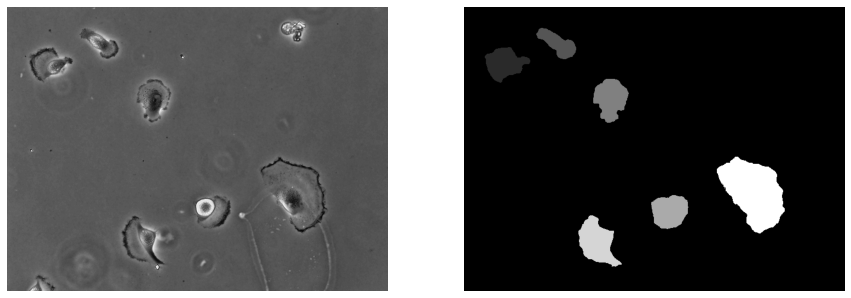

In [13]:
im = Image.open('PhC-C2DH-U373/01/t001.tif')
seg = Image.open('PhC-C2DH-U373/01_ST/SEG/man_seg001.tif')

f = plt.figure(figsize=(15,15))
f.add_subplot(1,2, 1)
plt.imshow(im, cmap='gray')
plt.axis('off')
f.add_subplot(1,2, 2)
plt.imshow(seg, cmap='gray')
plt.axis('off')
plt.show()

### DIC-C2DH-HeLa dataset
This downloads the DIC dataset from the Cell Tracking Challenge website and unzips it to /content/data

In [0]:
%%shell
# Download the DIC dataset
wget -nc https://data.celltrackingchallenge.net/training-datasets/DIC-C2DH-HeLa.zip
# Extract it 
unzip -qn DIC-C2DH-HeLa.zip

Example of the Hela dataset. Both the input image and the (silver) ground truth segmentation.

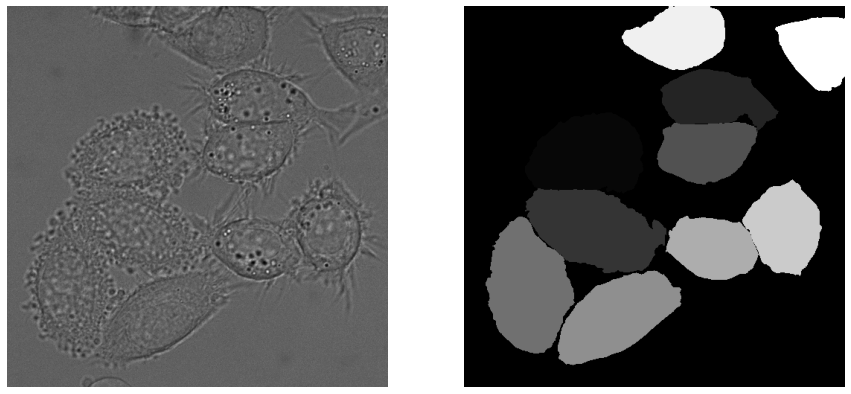

In [15]:
im = Image.open('DIC-C2DH-HeLa/01/t001.tif')
seg = Image.open('DIC-C2DH-HeLa/01_ST/SEG/man_seg001.tif')

f = plt.figure(figsize=(15,15))
f.add_subplot(1,2, 1)
plt.imshow(im, cmap='gray')
plt.axis('off')
f.add_subplot(1,2, 2)
plt.imshow(seg, cmap='gray')
plt.axis('off')
plt.show()

### ssTEM Dataset

Serial section Transmission Electron Microscopy (ssTEM) data set of the Drosophila first instar larva ventral nerve cord (VNC) [[4]](#scrollTo=fLp1tQzz17wE).

Download from http://www.ini.uzh.ch/~acardona/data.html

This is a tar.bz2 file, so instead of unzipping like the other two this one needs a different extraction approach.

In [0]:
%%shell
# Download the ssTEM dataset
wget -nc http://www.ini.uzh.ch/~acardona/data/tifs.tar.bz2
# Extract it 
tar -xvf tifs.tar.bz2
mkdir 'tifs/exportImages'
mkdir 'tifs/exportMasks'

While the PhC and DIC datasets simply have seperate files for each individual image and mask. The ssTEM dataset contains multi-layered TIFF files. So the next step for this dataset is to extract all the indiviual images and masks, as our U-Net model only handles single-layered images.

This code simply iterates over all the layers in the image and mask TIFF files and exports them to a different folder. 

In [17]:
im = Image.open('tifs/sections-180-220.tif')

for i, page in enumerate(ImageSequence.Iterator(im)):
    if i < 10:
        page.save('tifs/exportImages/sstemIm0%d.tif' % i)
    else:
        page.save('tifs/exportImages/sstemIm%d.tif' % i)

print('Images Done')

im2 = Image.open('tifs/membranes-neurites-glia.tif')

for i, page in enumerate(ImageSequence.Iterator(im2)):
    if i < 10:
        page.save('tifs/exportMasks/sstemMsk0%d.tif' % i)
    else:
        page.save('tifs/exportMasks/sstemMsk%d.tif' % i)
    
print('Masks Done')


Images Done
Masks Done


Example of ssTEM dataset. Both an input image and a segmentation ground truth. In this case the cells still have different colors as with the other two datasets. However, the border between the cells (or you could say the background) has the value 168.

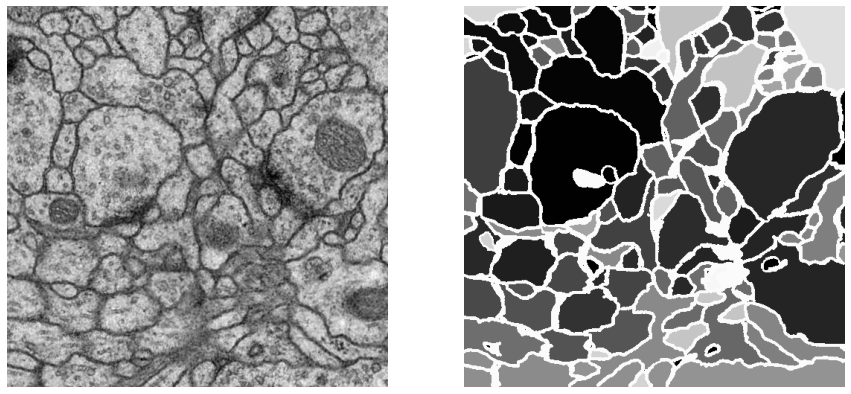

In [18]:
im = Image.open('tifs/exportImages/sstemIm00.tif')
seg = Image.open('tifs/exportMasks/sstemMsk00.tif')

f = plt.figure(figsize=(15,15))
f.add_subplot(1,2, 1)
plt.imshow(im, cmap='gray')
plt.axis('off')
f.add_subplot(1,2, 2)
plt.imshow(seg, cmap='gray')
plt.axis('off')
plt.show()

## Image deformation

In the datasets that are used there are only limited amount of images. To be able to train the network better without overtraining on the training data, data deformations are used. The data deformations use elastic deformations to slightly change the original image. The newly obtained image is equal to the original in terms of content, only the shapes have slightly changed. An example of such a deformation is shown in the two images below, where the first is an original image and the second is the deformed image. (In this example you can see the border being pushed in in the deformed image. This is for illustrative purposes. In the actual deformation of the datasets we use 'mirror' mode which mirrors the the image on the edges where it gets pushed in. This is done to get a complete image.)

![Original image.](https://drive.google.com/uc?id=1L0-1F5sXfAFciFjvKdDZ56EWQwIgxXtg)

![Deformed image](https://drive.google.com/uc?id=1j1uzy--QL80XvaIs48ufRhrjUbK8lz-k)

In this notebook the images are deformed on 3x3 points and with a standard deviation of 10. With these deformations it is possible to generated new training data from the original training data and thus train the network better with a lower risk on overfitting.

In [35]:
#@title  { run: "auto", vertical-output: true, display-mode: "form" }
#@markdown ### Select the dataset to be used in the rest of this project:
#@markdown (After connecting to a runtime you have to run this once, after that switching the dataset will autorun this cell)

datasetValue = 'ssTEM' #@param ["PhC-C2DH-U373", "DIC-C2DH-HeLa", "ssTEM"]
print('You selected', datasetValue)

PhC = {
    'rootPath' : 'PhC-C2DH-U373',
    'imgDir' : '01',
    'maskDir' : '01_ST/SEG'
}

DIC = {
    'rootPath' : 'DIC-C2DH-HeLa',
    'imgDir' : '01',
    'maskDir' : '01_ST/SEG'
}

ssTEM = {
    'rootPath' : 'tifs',
    'imgDir' : 'exportImages',
    'maskDir' : 'exportMasks'
}

dataset = []

if datasetValue == 'None':
    print('Please select another option...')
elif datasetValue == 'PhC-C2DH-U373':
    dataset = PhC
elif datasetValue == 'DIC-C2DH-HeLa':
    dataset = DIC
elif datasetValue == 'ssTEM':
    dataset = ssTEM
# elif datasetValue == 'All':
#     dataset = [PhC, DIC, ssTEM]

You selected ssTEM


For clarity and readability we define a deform_image function.

In [0]:
def deform_image(input_array, sigma, points):
    '''
    Input array contains the input image and the corresponding label image.
    All the images that are put in the input array receive the same deformation.

    The images are then deformed with elastic deformation on a 'points' number of points with a 'sigma' standard deviation from
    the normal distribution. It uses a forth order polynomial to get the smoothest result possible and the mirror mode to counter the black
    edges that would be created otherwise. 
    '''
    input_array_deformed = ed.deform_random_grid(input_array, sigma = sigma, points = points, order=4, mode='mirror', prefilter=False)
    return (input_array_deformed)

Depending on the dataset selected ([here](#scrollTo=x-m3nkzjjAxv)). The corresponding image and mask/labels directories are loaded.

Then all the images in these directories are put through the deform_image function and saved in the same directory, with 'aug_' and a number prepended to the filename. This way the dataset is doubled in size. 

(The number of dataset duplications can be changed easy in the next cell.)

In [0]:
numOfDatasetDuplications =  5#@param {type:"integer"}

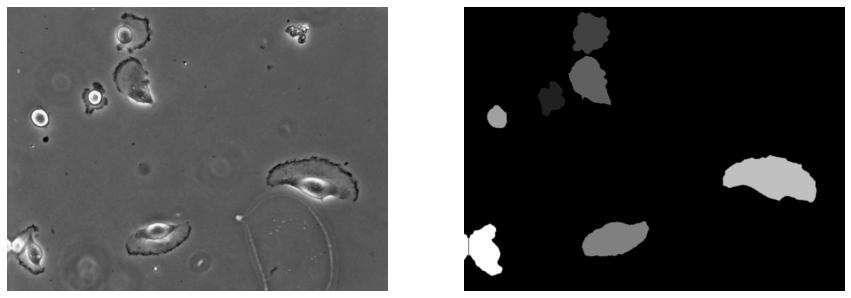

In [22]:
imgDir = os.path.join(dataset['rootPath'], dataset['imgDir'])
maskDir = os.path.join(dataset['rootPath'], dataset['maskDir'])

pathImages = []
for (dirpath, dirnames, filenames) in os.walk(imgDir):
    for filename in filenames:
        if 'aug' not in filename:
            imgPath = os.path.join(dirpath, filename)
            pathImages.append(imgPath)

pathImages = sorted(pathImages)

pathMasks = []
for (dirpath, dirnames, filenames) in os.walk(maskDir):
    for filename in filenames:
        if 'aug' not in filename:
            mskPath = os.path.join(dirpath, filename)
            pathMasks.append(mskPath)

pathMasks = sorted(pathMasks)

numOfImages = len(pathImages)

for j in trange(numOfDatasetDuplications):

    for i in trange(numOfImages):
        img = np.asarray(Image.open(pathImages[i]))
        mask = np.asarray(Image.open(pathMasks[i]))

        dfm_array = deform_image([img, mask], 10, 3)

        imgDir, imgName = os.path.split(pathImages[i])
        Image.fromarray(dfm_array[0]).save(os.path.join(imgDir, 'aug%02d_%03d_' % (j, i) + imgName))

        maskDir, mskName = os.path.split(pathMasks[i])
        Image.fromarray(dfm_array[1]).save(os.path.join(maskDir, 'aug%02d_%03d_' % (j, i) + mskName))


f = plt.figure(figsize=(15,15))
f.add_subplot(1,2, 1)
plt.imshow(dfm_array[0], cmap='gray')
plt.axis('off')
f.add_subplot(1,2, 2)
plt.imshow(dfm_array[1], cmap='gray')
plt.axis('off')
plt.show()




# Create Dataset

After retrieving all the data, the next step is to put it in a custom Pytorch dataset class object.

This is useful for (randomly) getting the data during the training (and evaluation) phase.

## Create custom dataset class

When creating a custom Pytorch dataset class the \_\_len\_\_ and \_\_getitem\_\_ functions (besides the \_\_init\_\_) are required. 

The \_\_len\_\_ makes sure it is known how many items the dataset holds. 

The \_\_getitem\_\_ function gets called internally when calling for the next item using the dataLoader functionality. It takes an image and its corresponding mask and returns them together when this function is called. When the number defined in \_\_len\_\_ is reached no new item is returned.

Before an image and a mask are returned there a few more steps performed on them. 

The first step is peformed only on the masks. Obviously in all the datasets the segmentations of the cells is defined with certain pixel values. In the masks of the PhC and DIC datasets the background is defined by the value 0 (black) and each pixel that belongs to a cell has incremental number. This means that the first cell is made up of only ones, the second cell of twos and so on. In the ssTEM dataset this is almost the same except for the fact that there is not really a background between the cells but more of a border due to the large amount of cells in each image. This border has the value 168 while the values of the cells range from 0-167 and in some cases even higher than 168). However, the output of the network has two output classes, either background (0) or cell (1). So for the PhC and DIC datasets all the values that are larger than 0 are put to 1 (and the background is kept at 0) and for the ssTEM dataset the pixels that have value 168 are put at 1 and the rest at 0.

The next step is cutting both the image and mask to a usable size. For the network it is important that the images are square and that each bypass has an even number in both width and in height. This means that only certain sizes are possible. The input images are cut into such a size that they are compatible with the network (after the padding). However, before they are used for training, a mirror padding is applied. This means that the edges of the images are mirrored outwards. This is done because throughout the network the edges of the images are slowly lost due to the convolutions. By using this mirror padding, the full original image can be segmented and the border pixels have 'natural' surrounding pixels. This last part is important for the convolution layers; if regular 'white' padding would have been applied here, it would mean that the quality of the segmentation would be lower on the border of the images due to less information on its surroundings.



In [0]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, imgDir, maskDir, transforms=None):
        self.root = root
        self.imgDir = imgDir
        self.maskDir = maskDir
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(root, imgDir))))

        self.masks = list(sorted(os.listdir(os.path.join(root, maskDir))))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.imgDir, self.images[idx])
        image = np.array(Image.open(image_path))

        mask_path = os.path.join(self.root, self.maskDir, self.masks[idx])
        mask = np.array(Image.open(mask_path))

        if self.root == 'tifs': # ssTEM dataset
            border = 168
            mask[mask != border] = 0
            mask[mask == border] = 1
        else:                   # PhC and DIC datasets
            mask[mask > 0] = 1                               
        
        minLength = np.min(image.shape)

        if minLength == 512:
            minLength = 504

        mask1 = mask[0:minLength, 0:minLength]                            #make sure the mask is square
        image1 = image[0:minLength, 0:minLength]                          #make sure the image is square
        image1 = np.pad(image1, 26, mode='reflect')   #mirror the edges of the image to compensate border loss in network
        mask1 = np.pad(mask1, 26, mode='reflect')     #mirror the edges of the mask to compensate border loss in network

        mask1 = mask1.astype(np.float64) 

        if self.transforms:
            image1 = self.transforms(image1)
            mask1 = self.transforms(mask1)

        return image1, mask1


Here we actually create the DataLoaders for accessing the training and testing data. We have selected a validation set size of 20 but this can easily be changed. The same goes for the batch size which we have set at four. The images and masks are randomly put in the DataLoaders. 

In the end it shows an example of the four images and masks that are retrieved during one call to the (training) DataLoader. 



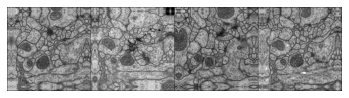

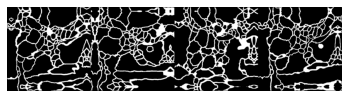

In [36]:
# Dataset creation

transform = transforms.Compose([transforms.ToTensor()])

Cst_DS = CustomDataset(dataset['rootPath'], dataset['imgDir'], dataset['maskDir'], transform)

torch.manual_seed(1)
indices = torch.randperm(len(Cst_DS)).tolist()

validateSetSize = 20

trainset = tudata.Subset(Cst_DS, indices[:-validateSetSize])
testset = tudata.Subset(Cst_DS, indices[-validateSetSize:])

trainloader = tudata.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)
testloader = tudata.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

dataiter = iter(trainloader)
images, masks = next(dataiter)

def imshow(img):
    npimg = img.numpy()
    npimg2 = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg2)
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(masks))



# Running U-net

## Connect google drive for saving and retrieving model

For saving and loading the trained models during the training and evaluationg stages we use Google drive. 

Run the code below to connect to your Google drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

If you want to run this on your own you can change the ProjectDir variable to a directory in you Google drive. In this directory the models will be saved.

In [0]:
ProjectDir = 'DL - Group 54'
rootPath = '/content/gdrive/My Drive/' + ProjectDir
!ls "$rootPath"

model_save_name = 'model_' + datasetValue + '.pt'
savePath = rootPath + '/' + model_save_name
print(savePath)


## Training the network

Here the function is defined that calculates the pixel loss. The first step in the function is to scale the outcomes of the network to the 0 or 1 scale of the labels. This means that all values below a certain threshold will be set to 0 and all values above the threshold to 1. The value of this threshold differs; it is chosen from a continuous array of thresholds. The lower and upper bound and the stepsize of this array are determined by the arguments of the function. When the output from the network is rescaled, the true positives, the true negative, the false positives and the false negatives are calculated. With these values the precision and recall can be calculated, which in turn are necessary for the F1 score calculation. The F1 score and the threshold value of the most optimal threshold are saved and returned by the function.

In [0]:
def pixel_loss(img_pred = np.ndarray, img_labels = np.ndarray, threshold_lower = 0.1, threshold_uppper = 0.9, step_size = 0.1):
    """
    This function calculates the pixel loss between the predicted image and the labelled image. The labels should be either 0 or 1.
    A pixel in the predicted image is either rightly or wrongly predicted. Therefore the predicted image is converted to zeros and ones.
    This conversion is done with a treshold. The treshhold will vary betwen the treshold_lower and threshold_upper with a stepsize of
    step_size. The threshold that results in the best F1 score is chosen and returned along with the pixel loss (1-F1).
    """
    
    thresholds = np.arange(threshold_lower, threshold_uppper+step_size, step_size)
    f1_best = 0
    thr_best = 999

    for threshold in thresholds:
        #scale the predictions to 0-1 values
        img_pred_temp = np.copy(img_pred)

        img_pred_temp[img_pred_temp > threshold] = 1
        img_pred_temp[img_pred_temp <= threshold] = 0

        #calculate the true/false positives/negatives:
        true_positive = np.sum((img_pred_temp == img_labels) & (img_labels == 1))
        false_positive = np.sum((img_pred_temp != img_labels) & (img_labels == 1))
        true_negative = np.sum((img_pred_temp == img_labels) & (img_labels ==0))
        false_negative = np.sum((img_pred_temp != img_labels) & (img_labels == 0))

        #calculate precision and recall
        #calculate F1 score
        if true_positive == 0:
            precision = 0
            recall = 0
            f1_score = 0
        else:
            precision = true_positive/(true_positive + false_positive)
            recall = true_positive/(true_positive + false_negative)
            f1_score = 2*precision*recall/(precision + recall)

        #update F1 score if necessary
        if f1_score > f1_best:
            f1_best = f1_score
            thr_best = threshold

    return(thr_best, 1-f1_best)

### Evaluation

The next function is for the validation step during the training.

In [0]:
def validate_model(model, criterion_used, validation_loader):

    running_val_loss = 0
    running_val_loss_pixel = 0
    model.eval()
    iterator = iter(validation_loader)

    with torch.no_grad():
        for i in trange(len(validation_loader.dataset)):
            
            try: # This is necessary because of a weird StopIteration error. Enumerate also would throw this exception.
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(validation_loader)
                inputs, labels = next(iterator)

            labels = labels.type(torch.LongTensor)
            
            labels1 = labels
            if labels1.shape[3] == 556:
                labels1 = labels[:,0,92:464, 92:464]  # Select the middle part of the labels
            else:
                labels1 = labels[:,0,92:480, 92:480]  # Select the middle part of the labels
            
            if use_gpu:
                inputs = inputs.cuda()
                labels1 = labels1.cuda()
                
            outputs = model(inputs)
            running_val_loss_pixel = 0
            
            for j in range(labels1.shape[0]):
                best_threshold, current_loss = pixel_loss(outputs[j, 1, :, :].cpu().numpy(), labels1[j, :, :].cpu().numpy(), -1, 1, 0.1)
                running_val_loss_pixel += current_loss
            
            loss = criterion(outputs, labels1) 
            running_val_loss += loss.item()
            

    return(running_val_loss/(i+1), running_val_loss_pixel/labels1.shape[0])

Now the network can be trained on the generated dataset. The available GPU is being used to speed up the process. (When using Google Colab check the settings whether GPU is selected). The used loss is the cross entropy loss and the optimiser has a learning rate of 0.01 and uses a momentum of 0.99.

The output image of the network has a smaller size than the input image of the network. Therefore the labels are also of a bigger size than the output image which poses a problem for the loss calculation. To solve this, the correct size from the labels is cut out and compared with the network output.

In [0]:
numOfEpochs =  30#@param {type:"integer"}

In [0]:
import gc

gc.collect()

unet = UNet(1,2)
cross_loss_list = []
pixel_loss_list = []
val_pixel_loss_list = []
val_loss_list = []
running_loss = 0
running_loss_pixel = 0


if use_gpu:
    unet = unet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr=0.01, momentum=0.99)

tl = trainloader

iterator = iter(tl)

if os.path.exists(savePath):

    checkpoint = torch.load(savePath)
    unet.load_state_dict(checkpoint['unet_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epochStart = checkpoint['epoch']
    loss = checkpoint['loss']
    cross_loss_list = checkpoint['cross_entropy_losses']
    pixel_loss_list = checkpoint['pixel_losses']
    val_loss_list = checkpoint['validation_losses']
    val_pixel_loss_list = checkpoint['validation_pixel_losses']

    unet.train()

else:
    epochStart = 0

for epoch in range(epochStart, numOfEpochs + 1): 
    print('epoch', epoch) # Show current epoch (tqdm doesn't play nice when using start index other than 0)
    running_loss = 0.0
    
    
    for i in trange(len(tl.dataset)):
        unet.train()
        
        try: # This is necessary because of a weird StopIteration error. Enumerate also would throw this exception.
            inputs, labels = next(iterator)
        except StopIteration:
            iterator = iter(tl)
            inputs, labels = next(iterator)

        labels = labels.type(torch.LongTensor)
 
        labels1 = np.copy(labels)
        if labels1.shape[3] == 556:
            labels1 = labels[:,0,92:464, 92:464]  # Select the middle part of the labels
        else:
            labels1 = labels[:,0,92:480, 92:480]  # Select the middle part of the labels
        
        if use_gpu:
            inputs = inputs.cuda()
            labels1 = labels1.cuda()
          
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = unet(inputs)
        
        loss = criterion(outputs, labels1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        number_of_checks_per_epoch = 4
        count_number = int(len(tl.dataset)/number_of_checks_per_epoch)

        if i % count_number == count_number-1:
            # Make sure that the values of the images are propper for dislplaying
            labels1_print_version = labels1.clone()
            labels1_print_version[labels1_print_version > 0] = 255
            outputs_print_version = outputs

            # Display the lables and the output of the network
            imshow(torchvision.utils.make_grid(labels1_print_version.unsqueeze(1).cpu()))
            imshow(torchvision.utils.make_grid(outputs_print_version[:, 1:2, :, :].cpu().detach()))

            for j in range(labels1.shape[0]):
              best_threshold, current_loss = pixel_loss(outputs[j, 1, :, :].cpu().detach().numpy(), 
                                                        labels1[j, :, :].cpu().detach().numpy(), -1, 1, 0.1)
              running_loss_pixel += current_loss
              print("The best threshold and the loss are: %1.1f \t %1.4f" %(best_threshold, current_loss))
            
            cross_loss_list.append(running_loss/count_number)
            pixel_loss_list.append(running_loss_pixel/labels1.shape[0])

            print(running_loss/count_number, " running loss")

            running_loss = 0
            running_loss_pixel = 0

            # Validate
            val_loss, val_pixel_loss = validate_model(unet, criterion, testloader)

            val_loss_list.append(val_loss)
            val_pixel_loss_list.append(val_pixel_loss)

            print(val_loss, " validation loss")

    unetDict = {
        'epoch' : epoch + 1,
        'unet_state_dict': unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'cross_entropy_losses': cross_loss_list,
        'pixel_losses': pixel_loss_list, 
        'validation_losses': val_loss_list,
        'validation_pixel_losses': val_pixel_loss_list
    }

    # Save the model to Google drive
    torch.save(unetDict, savePath)

# Plot the curves of the training loss, the pixel loss and the validation loss
x_axis = np.arange(0, len(val_loss_list)/number_of_checks_per_epoch, 1/number_of_checks_per_epoch)
title_string = datasetValue + " dataset" + nn_type
saving_string = title_string + ".png"

graph = plt.figure()
plt.plot(x_axis, cross_loss_list, 'r--', label="cross entropy loss - training")
plt.plot(x_axis, pixel_loss_list, 'b-.', label = 'pixel loss - training')
plt.plot(x_axis, val_loss_list, 'yo', label='cross entropy loss - validation')
plt.plot(x_axis, val_pixel_loss_list, 'gv', label='pixel loss - validation')
plt.legend()
plt.title(title_string )
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.figure(figsize=(40,20))

graph.savefig(saving_string, dpi = 300)

plt.show()


print('Finished Training')
gc.collect()

# Results

First the model was trained with 10 deformation duplicates per original image for 40 epochs. The results are shown below.

![10 def, without batch normalisation](https://drive.google.com/uc?id=1qMI-h5euigQ7Bqa8T1FFwpLf1FA96MaL)

The model learns steadily up to the moment around epoch 35, from that point on the validation losses no longer improve.

After training the network without batch normalisation, the network was also trained with this extra operation. From the figure below it is evident that the learning with batch normalisation went a lot quicker (note that this training already stops at 30 epochs). In terms of final performance the models with and without batch normalisation are comparable. The batch normalisation model reaches its top performance, in terms of the cross entropy validation loss, around epoch 8. From this point onward the cross entropy validation loss seems to suggect that the model starts overfitting on the training data. However, it is unclear to what extend this overfitting is harmful since the pixel validation loss stays constant. Nevertheless, it seems to be the safest option to stop training after 8 epochs if one were to use the model.

![10 def, with batch normalisation](https://drive.google.com/uc?id=1YnpzXBmC5LktV6wDdjsnKN71mb2Ngm-4)


# Conclusion

It is difficult to answer the question whether the paper from Ronneberger et al. [[1]](#scrollTo=C1KIiDas61F8) is reproducable. In this notebook a working reproduction of the U-net is created in the PyTorch framework. Additionally the performance on the ssTEM dataset approaches the performance as shown by Ronneberger et al. [[1]](#scrollTo=C1KIiDas61F8). Therefore the conclusion is that the paper is reproducable, although the reproduction (speed) was definitely aided by the many others on the internet that use U-nets.

Furthermore, it is worthy to note that it was unclear how many epochs and deformations were used by the original authors. This means that in this aspect it is not possible to compare the performance.

# References



[1] Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[2] Glioblastoma-astrocytoma U373 cells on a polyacrylamide substrate by Dr. S. Kumar. Department of Bioengineering, University of California at Berkeley, Berkeley CA (USA). [http://celltrackingchallenge.net/2d-datasets/](http://celltrackingchallenge.net/2d-datasets/)

[3] HeLa cells on a flat glass

Dr. G. van Cappellen. Erasmus Medical Center, Rotterdam, The Netherlands. [http://celltrackingchallenge.net/2d-datasets/](http://celltrackingchallenge.net/2d-datasets/)


[4] Cardona, A., Saalfeld, S., Preibisch, S., Schmid, B., Cheng, A., Pulokas, J., ... & Hartenstein, V. (2010). An integrated micro-and macroarchitectural analysis of the Drosophila brain by computer-assisted serial section electron microscopy. PLoS biology, 8(10). [doi:10.1371/journal.pbio.1000502](doi:10.1371/journal.pbio.1000502)

[5] Pytorch U-Net implementation by Heet Sankesara. 
https://github.com/Hsankesara/DeepResearch/tree/master/UNet